In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn import metrics

from ast import literal_eval

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression


import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model, stocks_numbers
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_length = 24000
stocks = stocks_numbers.chosen_stocks
should_save_fig = False

In [3]:
d_stocks = {}
d_cv_stocks = {}
d_test_stocks = {}
for s in stocks:
    d,  d_test = lob.load_prepared_data(s, length=data_length)
    d.index = pd.to_datetime(d['Unnamed: 0'].values)
    d_test.index = pd.to_datetime(d_test['Unnamed: 0'].values)
    d['prev_queue_imbalance'] = [None] + d['queue_imbalance'].iloc[0:len(d)-1].values.tolist()
    d.dropna(inplace=True)
    d_test['prev_queue_imbalance'] = [None] + d_test['queue_imbalance'].iloc[0:len(d_test)-1].values.tolist()
    d_test.dropna(inplace=True)
    d_stocks[s] = d
    d_test_stocks[s] = d_test

In [4]:
d_stocks['3459'].head()

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance,prev_queue_imbalance
2013-09-02 08:31:00,2013-09-02 08:31:00,"[(550.0, 4600.0), (590.0, 3500.0), (666.0, 956...","[(749.5, 19522.0), (750.0, 51865.0), (750.5, 1...",748.5,749.5,749.0,19522.0,8078.0,0.0,-0.414638,-0.573878
2013-09-02 08:32:00,2013-09-02 08:32:00,"[(550.0, 4600.0), (590.0, 3500.0), (666.0, 956...","[(749.5, 13371.0), (750.0, 51046.0), (750.5, 1...",748.5,749.5,749.0,13371.0,16818.0,0.0,0.114181,-0.414638
2013-09-02 08:33:00,2013-09-02 08:33:00,"[(550.0, 4600.0), (590.0, 3500.0), (666.0, 956...","[(749.5, 20645.0), (750.0, 51474.0), (750.5, 1...",748.5,749.5,749.0,20645.0,7206.0,0.0,-0.482532,0.114181
2013-09-02 08:34:00,2013-09-02 08:34:00,"[(550.0, 4600.0), (590.0, 3500.0), (666.0, 956...","[(749.5, 14676.0), (750.0, 51474.0), (750.5, 1...",748.5,749.5,749.0,14676.0,7206.0,0.0,-0.341376,-0.482532
2013-09-02 08:35:00,2013-09-02 08:35:00,"[(550.0, 4600.0), (590.0, 3500.0), (666.0, 956...","[(749.0, 9652.0), (749.5, 35846.0), (750.0, 42...",748.0,749.0,748.5,9652.0,5395.0,1.0,-0.282914,-0.341376


## SVM with queue imbalance

In [5]:
df_res = {}
for s in stocks:
    df_res_temp = pd.read_csv(
        '../svm_queue_imbalance/res_svm/svm_sigmoid_{}_len{}.csv'.format(s, data_length))
    df_res[s] = df_res_temp
    df_res[s].index = list(range(len(df_res[s])))


In [6]:
df_best_svm = pd.DataFrame()
for s in stocks:
    idx_max = df_res[s]['matthews'].idxmax()
    df_best_svm = df_best_svm.append(df_res[s].loc[idx_max])
df_best_svm

,C,Unnamed: 0,coef0,f1,features,gamma,kappa,kernel,matthews,precision,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
25,0.001,25.0,0.010,0.497593,que,10.000,0.099606,sigmoid,0.101253,0.491552,...,0.084010,0.473642,0.563770,0.542363,0.487147,0.077044,0.077467,0.472729,0.504807,0.538808
177,10.000,177.0,1.000,0.346803,que,0.010,0.093323,sigmoid,0.123657,0.235997,...,0.130553,0.247441,0.635929,0.582217,0.363559,0.108610,0.135556,0.254739,0.634881,0.584637
34,0.001,34.0,10.000,0.444472,que,100.000,0.111446,sigmoid,0.126050,0.345721,...,-0.023102,0.282660,0.554722,0.487429,0.437130,0.105751,0.119926,0.343775,0.611828,0.564972
180,10.000,180.0,0.001,0.425296,que,0.100,0.140375,sigmoid,0.145372,0.365136,...,0.127401,0.367224,0.494805,0.568335,0.418693,0.119653,0.125082,0.352671,0.517453,0.567918
219,100.000,219.0,1.000,0.293089,que,0.010,0.105413,sigmoid,0.146541,0.189271,...,0.134776,0.192221,0.714385,0.594016,0.319473,0.111632,0.151331,0.210574,0.662441,0.604843
141,1.000,141.0,1.000,0.519890,que,0.100,0.061360,sigmoid,0.062361,0.479484,...,0.063964,0.477580,0.597335,0.531897,0.524661,0.063846,0.065219,0.477838,0.582866,0.532586
254,1000.000,254.0,0.100,0.425378,que,0.001,0.109039,sigmoid,0.122881,0.332377,...,0.118834,0.324307,0.572923,0.566919,0.409281,0.108513,0.118624,0.323408,0.558131,0.566700
63,0.010,63.0,1.000,0.420016,que,1.000,0.138216,sigmoid,0.146256,0.345570,...,0.125885,0.333817,0.604538,0.570263,0.417605,0.108017,0.116642,0.340162,0.549144,0.563929
102,0.100,102.0,0.001,0.261750,que,1.000,0.078826,sigmoid,0.091470,0.208937,...,0.021764,0.151473,0.514503,0.515508,0.218879,0.037614,0.048580,0.152842,0.455017,0.534461
180,10.000,180.0,0.001,0.455860,que,0.100,0.123911,sigmoid,0.135066,0.366351,...,0.147290,0.385433,0.564751,0.579239,0.464308,0.153763,0.162579,0.385886,0.583737,0.587800


In [7]:
print(df_best_svm[['stock', 'kernel', 'C', 'gamma', 'coef0']].to_latex())

\begin{tabular}{lrlrrr}
\toprule
{} &    stock &   kernel &         C &     gamma &   coef0 \\
\midrule
25  &   9061.0 &  sigmoid &     0.001 &    10.000 &   0.010 \\
177 &   3459.0 &  sigmoid &    10.000 &     0.010 &   1.000 \\
34  &   4549.0 &  sigmoid &     0.001 &   100.000 &  10.000 \\
180 &   9761.0 &  sigmoid &    10.000 &     0.100 &   0.001 \\
219 &   4851.0 &  sigmoid &   100.000 &     0.010 &   1.000 \\
141 &   9062.0 &  sigmoid &     1.000 &     0.100 &   1.000 \\
254 &  11869.0 &  sigmoid &  1000.000 &     0.001 &   0.100 \\
63  &  12255.0 &  sigmoid &     0.010 &     1.000 &   1.000 \\
102 &   2748.0 &  sigmoid &     0.100 &     1.000 &   0.001 \\
180 &   4320.0 &  sigmoid &    10.000 &     0.100 &   0.001 \\
34  &  11583.0 &  sigmoid &     0.001 &   100.000 &  10.000 \\
218 &   4799.0 &  sigmoid &   100.000 &     0.010 &   0.100 \\
57  &   9268.0 &  sigmoid &     0.010 &     1.000 &   1.000 \\
40  &  10470.0 &  sigmoid &     0.001 &  1000.000 &  10.000 \\
171 &   9058.0

In [8]:
 from sklearn import utils

def get_classes_weights(y_train):
    classes = np.unique(y_train)
    class_weight_list = utils.class_weight.compute_class_weight('balanced', classes, y_train)
    class_weights = {classes[0]: class_weight_list[0], classes[1]: class_weight_list[1]}
    return class_weights

def fit_best_svm_classifier(df_best_svm, df, stock=None):
    stock = int(stock)
    gamma = df_best_svm[df_best_svm['stock'] == stock]['gamma'].values[0]
    coef0 = df_best_svm[df_best_svm['stock'] == stock]['coef0'].values[0]
    c = df_best_svm[df_best_svm['stock'] == stock]['C'].values[0]
    kernel = df_best_svm[df_best_svm['stock'] == stock]['kernel'].values[0]

    X = df['queue_imbalance'].values.reshape(-1, 1)
    y = df['mid_price_indicator']
   
    weights = get_classes_weights(y)
    clf = SVC(gamma=gamma, C=c, coef0=coef0, kernel=kernel, random_state=23131, class_weight=weights)
    clf.fit(X, y)
    return clf
    

In [9]:
def get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock):
    scores = {'stock': stock}
    for func_name, func in functions_to_run.items():
        for df_name, df in dfs.items():
            pred = log_clf.predict(df['queue_imbalance'].values.reshape(-1, 1))
            df['pred'] = pred
            scores['{}_{}'.format(df_name, func_name)] = func(df['mid_price_indicator'], pred)
    return scores
            
functions_to_run = {'precision': metrics.precision_score, 'roc_auc': metrics.roc_auc_score,
                   'f1_score': metrics.f1_score, 'recall': metrics.recall_score, 
                   'matthews': metrics.matthews_corrcoef, 'kappa': metrics.cohen_kappa_score}
scores = []
for stock in stocks:
    log_clf = fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock)
    dfs = {'train': d_stocks[stock], 'test': d_test_stocks[stock], }
    res_validation = model.validate_model(
        fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock), 
        d_stocks[stock][['queue_imbalance']], d_stocks[stock]['mid_price_indicator'])
    res = get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock)
    res = {**res, **res_validation}
    scores.append(res)
df_scores = pd.DataFrame(scores, index=stocks)

In [10]:
def convert_scores(df, column):
    scores = []
    for i, row in df.iterrows():
        scores.append(np.mean(row[column]))
    return scores
scores_columns = ['f1', 'kappa', 'matthews', 'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']

for col in scores_columns:
    df_scores[col] = convert_scores(df_scores, col)
df_scores

,f1,kappa,matthews,precision,recall,roc_auc,stock,test_f1_score,test_kappa,test_matthews,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
9061,0.497593,0.099606,0.101253,0.491552,0.513918,0.550135,9061,0.514865,0.087674,0.089317,...,0.084010,0.473642,0.563770,0.542363,"[0.48513827862496767, 0.46519202062695075, 0.4...","[0.07541622814166549, 0.07436635023761451, 0.0...","[0.07549759566248633, 0.0743840975752264, 0.08...","[0.47291509196271103, 0.47113798790544253, 0.4...","[0.49801008224993365, 0.45939426427231306, 0.4...","[0.5379477368473236, 0.5370659747472899, 0.542..."
3459,0.346803,0.093323,0.123657,0.235997,0.659755,0.578305,3459,0.355052,0.108968,0.131771,...,0.130553,0.247441,0.635929,0.582217,"[0.36643219368558805, 0.37091264031234755, 0.3...","[0.11068791437404635, 0.11388203740888381, 0.1...","[0.1375948325984511, 0.14128969867782512, 0.13...","[0.2574712643678161, 0.2611683848797251, 0.253...","[0.6352807714123653, 0.6397306397306397, 0.618...","[0.5856668148931979, 0.5876170122173291, 0.586..."
4549,0.444472,0.111446,0.126050,0.345721,0.628882,0.568979,4549,0.369752,-0.010462,-0.012427,...,-0.023102,0.282660,0.554722,0.487429,"[0.4154952598888526, 0.41458299725762215, 0.44...","[0.1133391131902024, 0.10787921816098733, 0.10...","[0.11717896366058196, 0.1121591275914303, 0.12...","[0.35592271072528703, 0.3514770240700219, 0.33...","[0.49901845308205733, 0.5053086905230043, 0.66...","[0.5633648432454638, 0.5608879266267561, 0.570..."
9761,0.425296,0.140375,0.145372,0.365136,0.511876,0.579031,9761,0.418251,0.107302,0.110216,...,0.127401,0.367224,0.494805,0.568335,"[0.4483916083916084, 0.4189549662639259, 0.407...","[0.10629670812162728, 0.1058349086570548, 0.11...","[0.11686657327253876, 0.11140406459736009, 0.1...","[0.3568566340160285, 0.34829115575267416, 0.34...","[0.6030850263355907, 0.5255905511811023, 0.492...","[0.5634511995037109, 0.5608550977409149, 0.565..."
4851,0.293089,0.105413,0.146541,0.189271,0.654920,0.606391,4851,0.281892,0.085375,0.131945,...,0.134776,0.192221,0.714385,0.594016,"[0.31987991994663106, 0.3283737024221453, 0.32...","[0.09450526395297976, 0.10938668717232536, 0.1...","[0.13215161824598573, 0.14791349497697015, 0.1...","[0.20975503062117234, 0.21781042001377093, 0.2...","[0.6734550561797753, 0.6669009135628953, 0.657...","[0.5892956694403876, 0.6000897336918831, 0.608..."
9062,0.519890,0.061360,0.062361,0.479484,0.568150,0.531206,9062,0.524476,0.050556,0.052097,...,0.063964,0.477580,0.597335,0.531897,"[0.5312393308296347, 0.5292244712303844, 0.528...","[0.06732105946098077, 0.06276835314999507, 0.0...","[0.06900973402586912, 0.06437256470834406, 0.0...","[0.47837671654027464, 0.47616124411704525, 0.4...","[0.5972364380757421, 0.5955976452521116, 0.597...","[0.5344496493887118, 0.5321284199693517, 0.532..."
11869,0.425378,0.109039,0.122881,0.332377,0.606232,0.567714,11869,0.412271,0.099398,0.104974,...,0.118834,0.324307,0.572923,0.566919,"[0.39735772357723576, 0.3945140535049103, 0.40...","[0.1144433911912599, 0.11096215581148583, 0.10...","[0.12202325950135805, 0.11857469519514513, 0.1...","[0.3214579336804604, 0.3181321682140907, 0.320...","[0.5201773835920177, 0.5191622103386809, 0.557...","[0.5687440240989454, 0.5669410804817923, 0.566..."
12255,0.420016,0.138216,0.146256,0.345570,0.537134,0.581062,12255,0.415247,0.096768,0.108394,...,0.125885,0.333817,0.604538,0.570263,"[0.427263479145473, 0.42742276766821835, 0.428...","[0.0961386723705897, 0.09462290018094621, 0.11...","[0.10595648786121947, 0.10839509666510291, 0.1...","[0.33738811108560934, 0.32664941785252266, 0.3...","[0.5824088748019017, 0.6181150550795593, 0.608...","[0.5584194027291238, 0.5601732431916764, 0.571..."
2748,0.261750,0.078826,0.091470,0.208937,0.454939,0.554845,2748,0.216625,-0.005671,-0.008427,...,0.021764,0.151473,0.514503,0.515508,"[0.1970746728252502, 0.20774487471526198, 0.19...","[0.056794

In [11]:
pivots = []
print('Pivot values')
for i in df_scores.index:
    stock = i
    df = d_stocks[stock]
    
    pivot = np.mean([np.min(df[df['pred'] == 1]['queue_imbalance']), 
                    np.max(df[df['pred'] == 0]['queue_imbalance'])])
    pivots.append(pivot)
df_scores['pivot'] = pivots
df_scores[['pivot', 'stock']]

Pivot values


,pivot,stock
9061,-0.000036,9061
3459,0.046621,3459
4549,-0.000026,4549
9761,0.171668,9761
4851,-0.050287,4851
9062,-0.090466,9062
11869,0.033717,11869
12255,-0.000888,12255
2748,-0.000039,2748
4320,0.098337,4320


In [12]:
df_pivot = df_scores[['pivot', 'stock']]
df_pivot['stock'] = df_pivot['stock'].values.astype(np.int64)

In [13]:
df_log = pd.read_csv('que_log_pivot.csv')
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 3 columns):
Unnamed: 0    15 non-null int64
pivot         15 non-null float64
stock         15 non-null int64
dtypes: float64(1), int64(2)
memory usage: 440.0 bytes


In [14]:
df_pivot = pd.merge(df_pivot, df_log[['pivot', 'stock']], 
                    on='stock', suffixes=['', '_log'])

In [15]:
df_pivot.index = df_pivot['stock']
df_pivot.drop(columns=['stock'], inplace=True)
df_pivot

,pivot,pivot_log
stock,,
9061,-0.000036,0.023023
3459,0.046621,0.096860
4549,-0.000026,0.032053
9761,0.171668,0.043341
4851,-0.050287,0.089948
9062,-0.090466,0.012105
11869,0.033717,0.037273
12255,-0.000888,0.046640
2748,-0.000039,0.038263


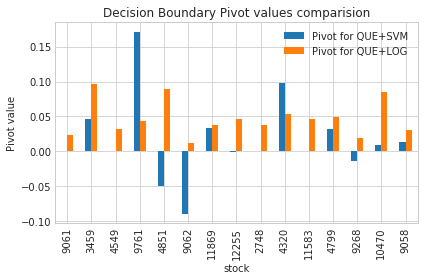

In [16]:
df_pivot.plot(kind='bar')
plt.legend(['Pivot for QUE+SVM', 'Pivot for QUE+LOG'])
plt.title('Decision Boundary Pivot values comparision')
plt.ylabel('Pivot value')
plt.tight_layout()
plt.savefig('que_svm_log_pivot_sigmoid.png')

In [17]:
df_pivot['stock'] = df_pivot.index
df_pivot[['stock', 'pivot']].to_csv('que_svm_sig_pivot.csv')